In [21]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))

In [22]:
set.seed(42)
getwd()

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Lymphoid/code"

In [23]:
coembed <- readRDS("../data/coembed/coembed.Rds")
coembed

An object of class Seurat 
159644 features across 6132 samples within 3 assays 
Active assay: RNA (28933 features, 2000 variable features)
 2 other assays present: peaks, GeneActivity
 4 dimensional reductions calculated: pca, umap, harmony, umap_harmony

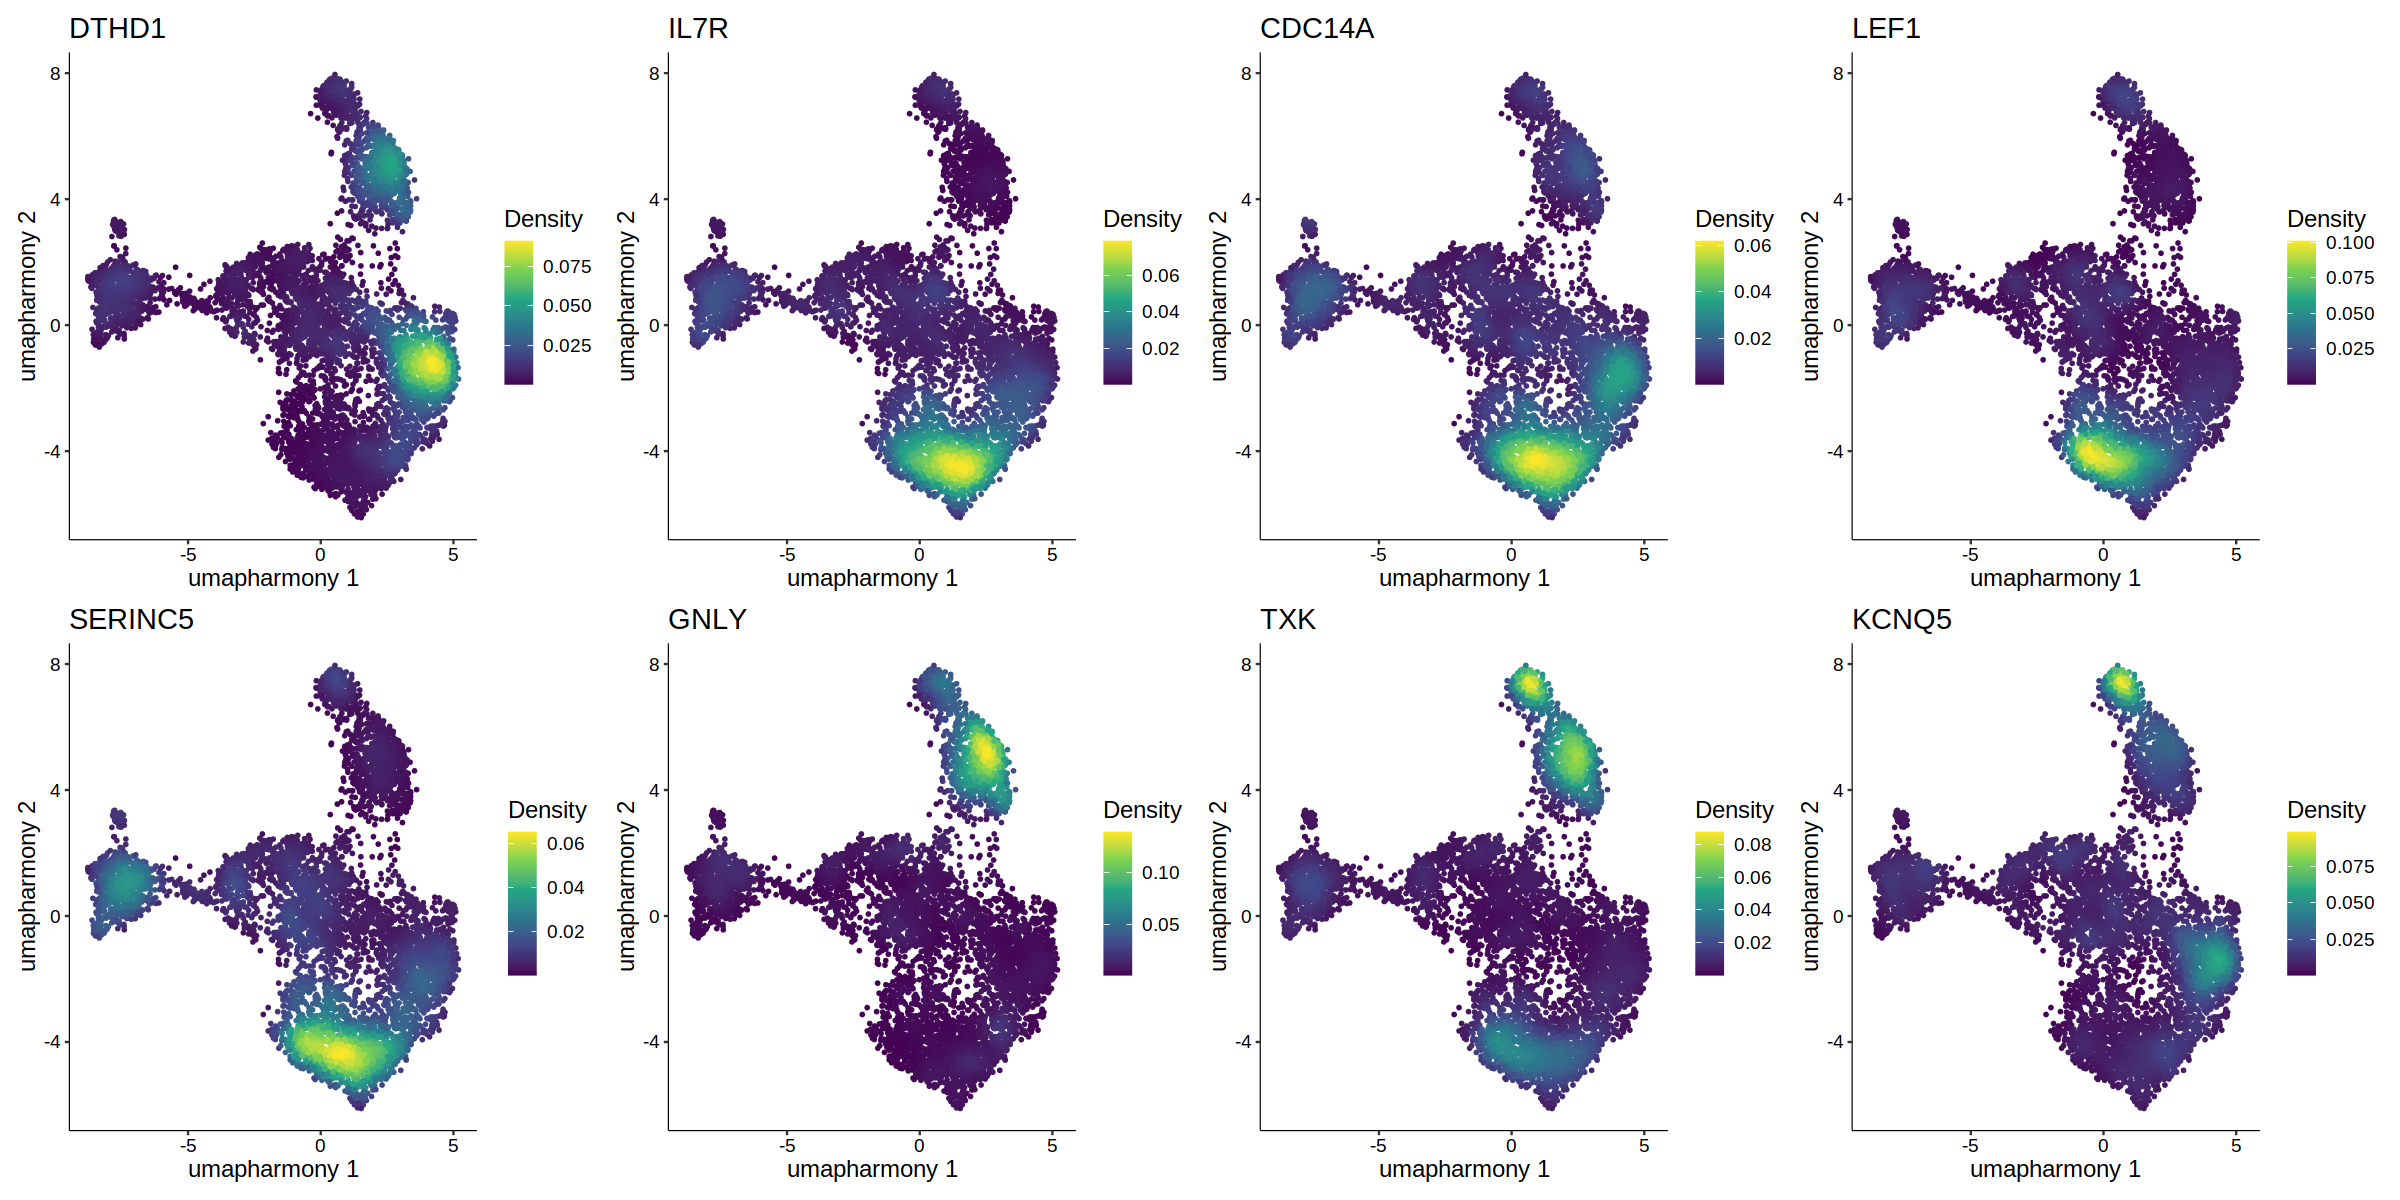

In [24]:
options(repr.plot.height = 10, repr.plot.width = 20)

ps1 <- plot_density(coembed, features=c("DTHD1",
                                       "IL7R", "CDC14A",
                                       "LEF1", "SERINC5",
                                       "GNLY", "TXK", "KCNQ5"), reduction="umap_harmony", combine = FALSE)

patchwork::wrap_plots(ps1, nrow = 2)

In [25]:
## get number of cells per cluster and sample
df_count <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., tech == "RNA") %>%
    group_by(orig.ident, RNA_snn_res.0.9) %>%
    summarise(count = n()) %>%
    tidyr::pivot_wider(names_from = RNA_snn_res.0.9, values_from = count, values_fill = 0)

write.csv(df_count, "../data/coembed/stat_cell_counts_per_sample_rna.csv", row.names = FALSE)

`summarise()` has grouped output by 'orig.ident'. You can override using the `.groups` argument.



In [26]:
coembed.sub <- subset(coembed, RNA_snn_res.0.9 %in% c(1, 2, 3, 4, 8))

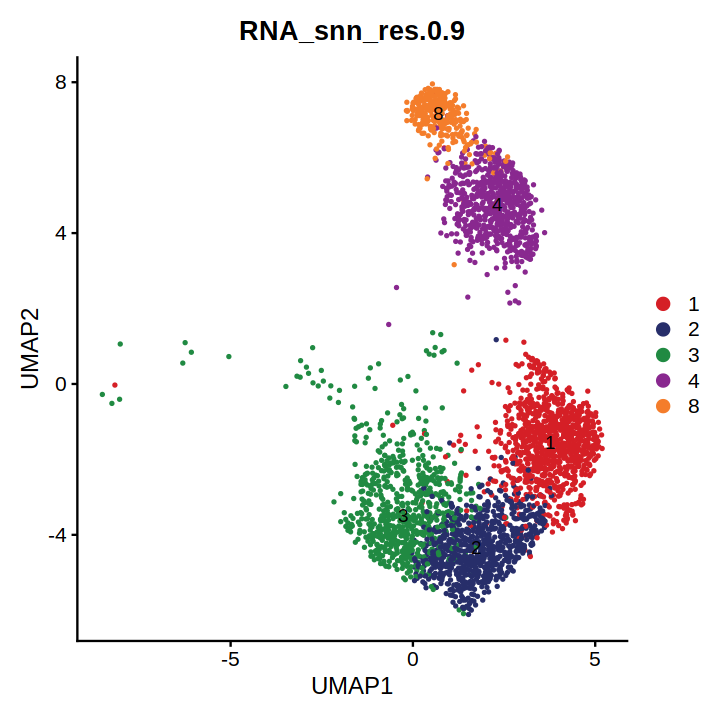

In [27]:
cols.clusters <- ArchR::paletteDiscrete(coembed.sub@meta.data[, "RNA_snn_res.0.9"])

options(repr.plot.height = 6, repr.plot.width = 6)

p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.0.9", label = TRUE,
             reduction = "umap_harmony", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [28]:
coembed.sub <- RunUMAP(coembed.sub, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony_v2",
               reduction.ke = 'umap_harmony_v2_',
              verbose = FALSE,
                   min.dist = 0.4)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_harmony_v2_ to umapharmonyv2_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to umapharmonyv2_”


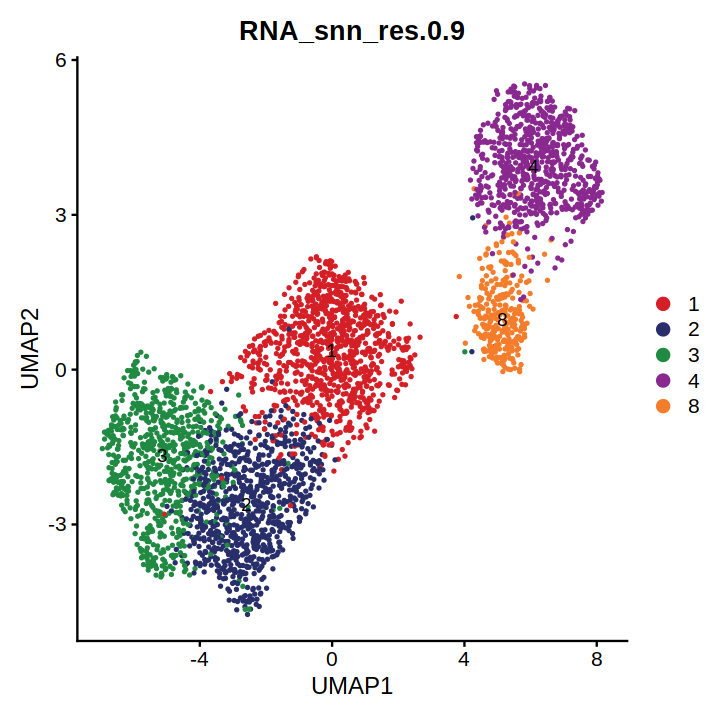

In [29]:
p <- DimPlot(coembed.sub, group.by = "RNA_snn_res.0.9", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, cols = cols.clusters) +
    xlab("UMAP1") + ylab("UMAP2")

p

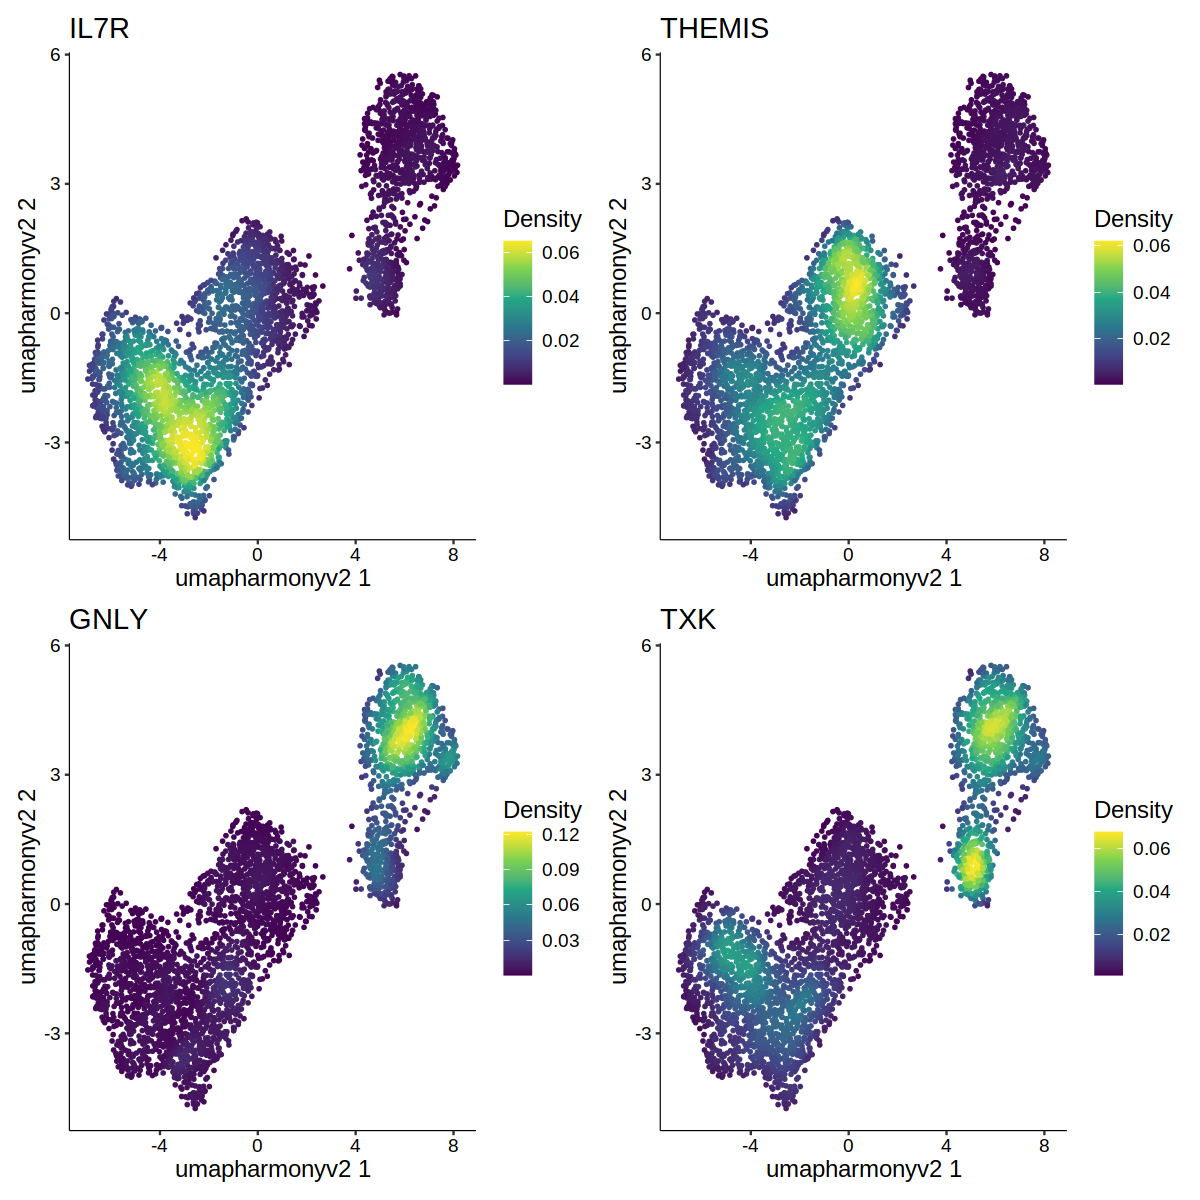

In [35]:
options(repr.plot.height = 10, repr.plot.width = 10)

ps1 <- plot_density(coembed.sub, features=c("IL7R", ## CD4
                                        "THEMIS", ## CD8
                                        "GNLY", # NK
                                        "TXK"# NKT
                                       ), reduction="umap_harmony_v2", combine = FALSE)

patchwork::wrap_plots(ps1, nrow = 2)

In [36]:
## add annotation
new.cluster.ids <- c("1" = "CD8",
               "2" = "CD4",
               "3" = "CD4",
               "4" = "NK",
               "8" = "NK_T")

Idents(coembed.sub) <- "RNA_snn_res.0.9"

coembed.sub <- RenameIdents(coembed.sub, new.cluster.ids)
coembed.sub$annotation <- Idents(coembed.sub)

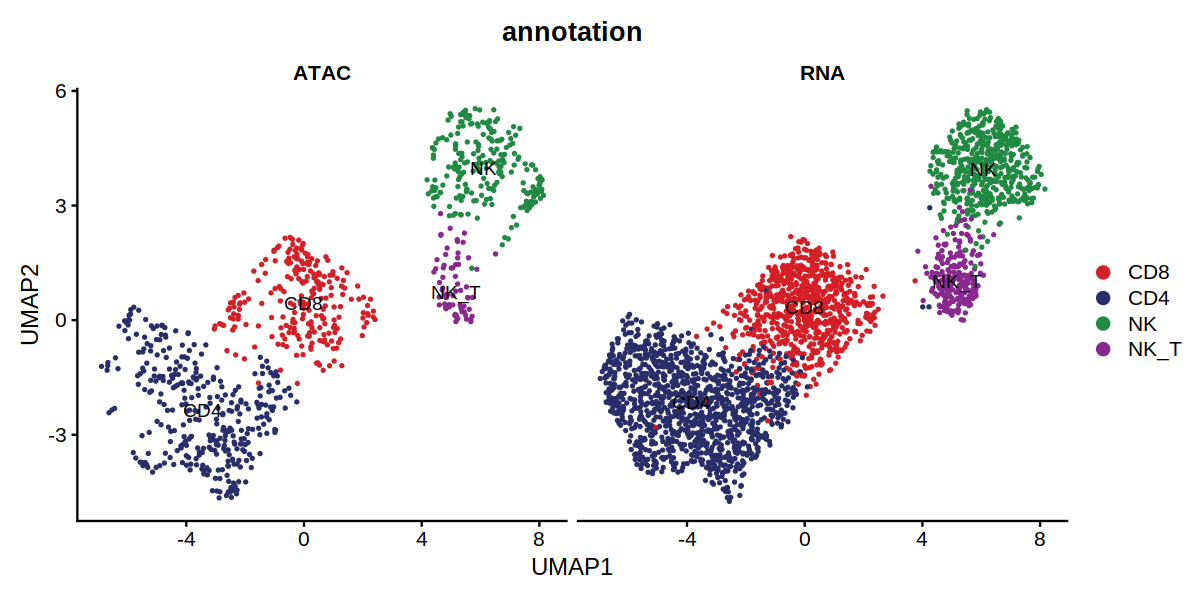

In [38]:
options(repr.plot.width = 10, repr.plot.height = 5)

cols.celltype <- ArchR::paletteDiscrete(coembed.sub$annotation)

p <- DimPlot(coembed.sub, group.by = "annotation", label = TRUE,
             reduction = "umap_harmony_v2", shuffle = TRUE, split.by = "tech", cols=cols.celltype) +
    xlab("UMAP1") + ylab("UMAP2")

p

In [39]:
meta.data <- as.data.frame(coembed.sub@meta.data)

`summarise()` has grouped output by 'patient'. You can override using the `.groups` argument.



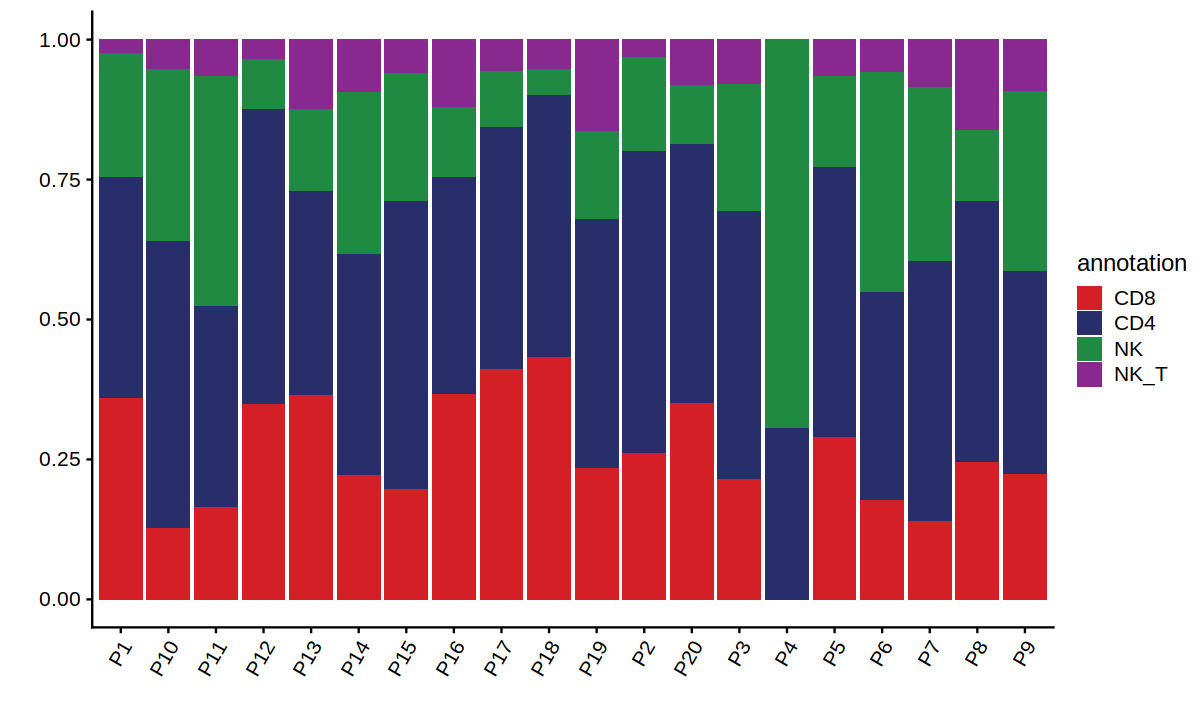

In [40]:
df_plot <-  meta.data %>%
    group_by(patient, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.celltype) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.



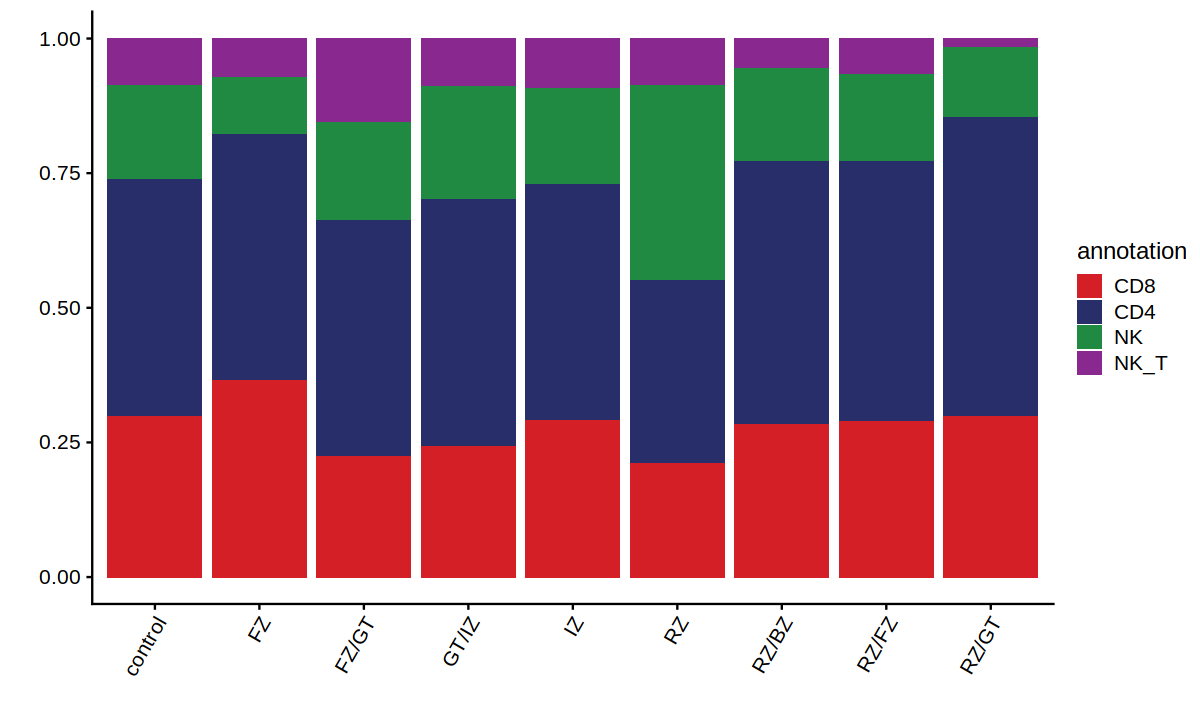

In [41]:
df_plot <- meta.data %>%
    group_by(region, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(region, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.celltype) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 10, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_group'. You can override using the `.groups` argument.



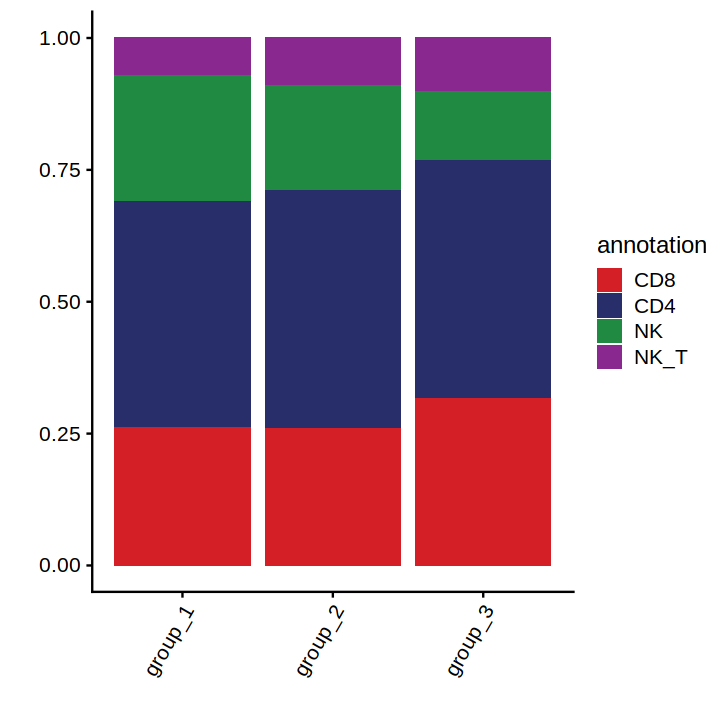

In [42]:
df_plot <- meta.data %>%
    group_by(patient_group, annotation) %>%
    summarise(counts = n()) %>%
    mutate(cell_proportion = counts / sum(counts))

p1 <- ggplot(df_plot, aes(patient_group, cell_proportion, fill=annotation)) + 
    geom_bar(stat="identity", position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = cols.celltype) +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))


options(repr.plot.width = 6, repr.plot.height = 6)

p1

`summarise()` has grouped output by 'patient_region_id'. You can override using the `.groups` argument.



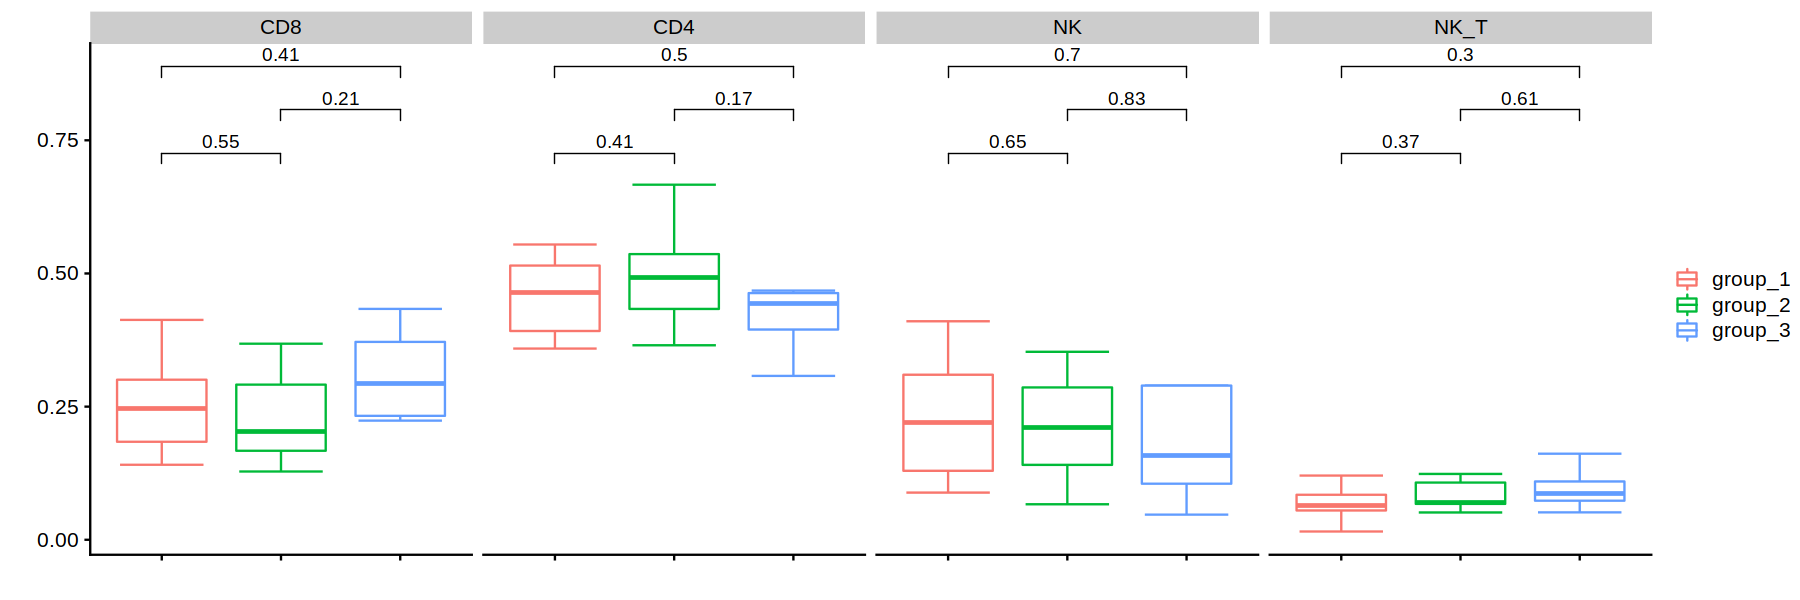

In [43]:
df_plot <- meta.data %>% 
            group_by(patient_region_id, annotation) %>%
            summarise(counts = n()) %>%
            mutate(proportion = counts / sum(counts))

df_anno <- coembed@meta.data %>%
    as.data.frame() %>%
    subset(., select = c("patient_region_id", "patient_group")) %>%
    unique()

df_plot <- merge.data.frame(df_plot, df_anno)
    
    p <- ggplot(data = df_plot, aes(x = patient_group, y = proportion)) +
    geom_boxplot2(aes(color = patient_group)) +
    facet_wrap(~annotation, nrow = 1) +
    stat_compare_means(comparisons = list(c("group_1", "group_2"),
                                         c("group_2", "group_3"),
                                         c("group_1", "group_3")),
                   method = "wilcox.test") +
    theme_cowplot() +
    xlab("") + ylab("") +
    theme(axis.text.x = element_blank(),
         legend.title = element_blank())

options(repr.plot.width = 15, repr.plot.height = 5)

print(p)

In [44]:
Idents(coembed.sub) <- as.character(Idents(coembed.sub))
#Idents(coembed.sub) <- "RNA_snn_res.0.9"

Calculating cluster CD4

Calculating cluster CD8

Calculating cluster NK

Calculating cluster NK_T



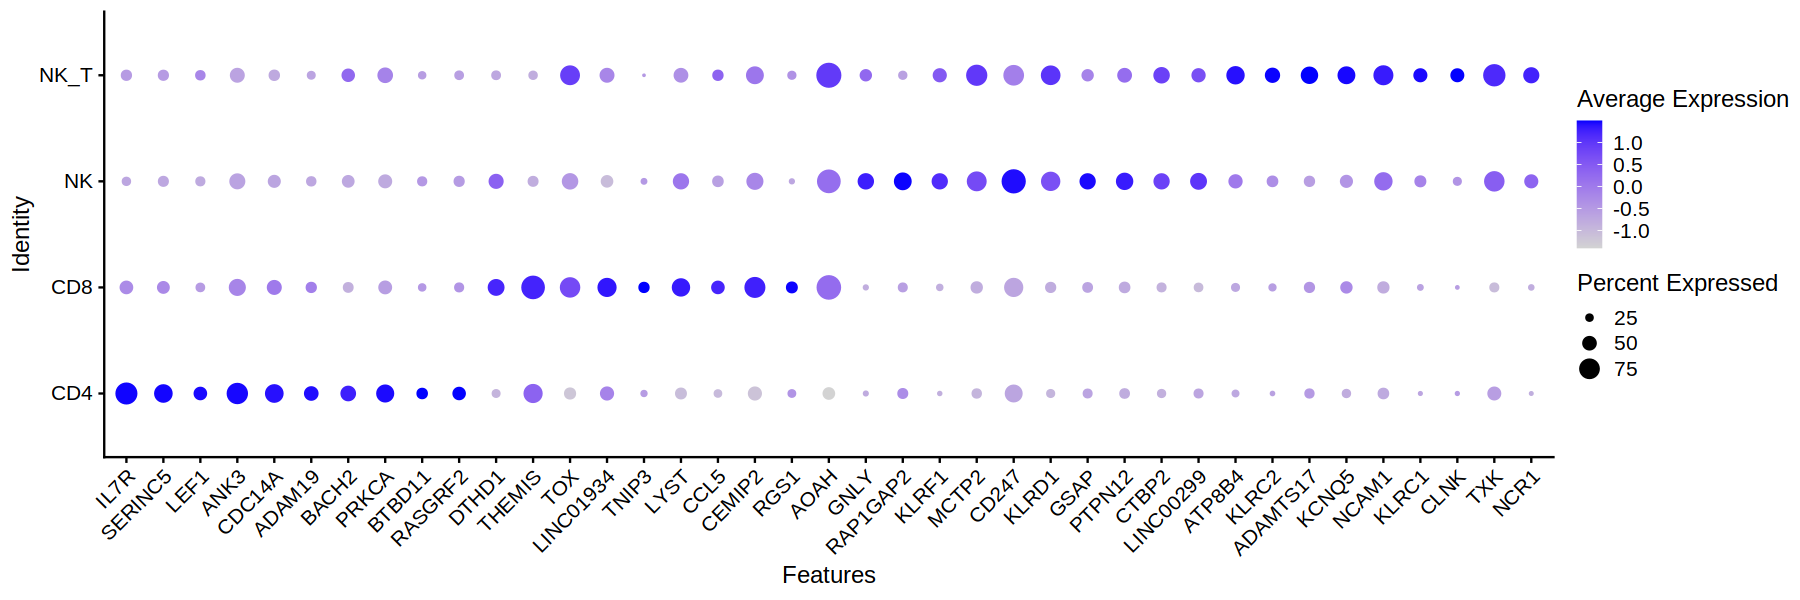

In [45]:
all.markers <- FindAllMarkers(coembed.sub, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
    
df <- all.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)

p <- DotPlot(coembed.sub, features = unique(df$gene)) + RotatedAxis()
    
options(repr.plot.height = 5, repr.plot.width = 15)

print(p)

In [19]:
if(!dir.exists("../data/coembed/MarkerGenesAfterAnnotation")){
    dir.create("../data/coembed/MarkerGenesAfterAnnotation")
}

In [20]:
markerList <- split(all.markers, all.markers$cluster)
    
    for(i in 1:length(markerList)){
        markerList[[i]] <- markerList[[i]][order(-markerList[[i]]$avg_log2FC), ]
    }
    
    WriteXLS::WriteXLS(markerList,
                   ExcelFileName = glue::glue("../data/coembed/MarkerGenesAfterAnnotation/res.0.9.xlsx"),
                   SheetNames = names(markerList))

saveRDS(all.markers, glue::glue("../data/coembed/MarkerGenesAfterAnnotation/res.0.9.rds"))

In [ ]:
saveRDS(coembed.sub, file = "../data/coembed/coembed.annotation.Rds")